In [10]:
from hydra import initialize, compose
import json
from rdkit import Chem
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.standardize import standardize_mol
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [11]:
with initialize(version_base=None, config_path="./conf/filepaths"):
    filepaths = compose(config_name="filepaths")

In [12]:
entries = {}
for i in range(0, 11):
    with open(Path(filepaths.raw_mcsa) / f"entries_{i}.json", "r") as f:
        entries = {**entries, **json.load(f)}

mech_ct = 0
detailed_ct = 0
for id, entry in entries.items():
    mechanisms = entry['reaction']['mechanisms']
    if mechanisms is None:
        continue

    for mech in mechanisms:
        mech_ct += 1
        if mech['is_detailed']:
            detailed_ct += 1

print(f"Total number of mechanisms: {mech_ct}")
print(f"Number of detailed mechanisms: {detailed_ct} ({detailed_ct/mech_ct*100:.2f}%)")
print(f"Total number of entries: {len(entries)}")


Total number of mechanisms: 1166
Number of detailed mechanisms: 887 (76.07%)
Total number of entries: 1003


In [13]:
mech_df = pd.read_parquet(Path(filepaths.processed_data) / 'mcsa' / "distilled_mech_reactions.parquet")
mech_df["mech_atoms"] = mech_df["mech_atoms"].apply(rc_to_nest)
mech_df['reaction_center'] = mech_df['reaction_center'].apply(rc_to_nest)
n_unique = len(set(mech_df[["entry_id", "mechanism_id"]].apply(tuple, axis=1)))
print(f"{n_unique/detailed_ct*100:.2f}% of detailed mechanisms have been processed")
mech_df.head(10)

75.87% of detailed mechanisms have been processed


entry_id  mechanism_id                                             smarts  \
0         1             1             NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O   
1         1             1             NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O   
2         2             2  *C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...   
3         2             2  *C(=O)NC(C(=O)O)C1NC(C(=O)O)C(C)(C)S1>>*C(=O)N...   
4         2             1  *C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...   
5         2             1  *C(=O)NC(C(=O)O)C1NC(C(=O)O)C(C)(C)S1>>*C(=O)N...   
6         3             1  *N1C=CCC(C(N)=O)=C1.O=C1C=CC(=O)C=C1>>*[n+]1cc...   
7         3             1  *[n+]1cccc(C(N)=O)c1.Oc1ccc(O)cc1>>*N1C=CCC(C(...   
8         4             2                                        O=NO>>N=O.O   
9         4             2                                        N=O.O>>O=NO   

                                           am_smarts  \
0  [NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...   
1  [NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...   
2  [*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...   
3  [*:33][C:32](=[O:35])[NH:30][CH:16]([C:17](=[O...   
4  [*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...   
5  [*:51][C:50](=[O:52])[NH:48][CH:33]([C:35](=[O...   
6  [*:53][N:38]1[CH:37]=[CH:36][CH2:41][C:40]([C:...   
7  [*:53][n+:38]1[cH:37][cH:36][cH:41][c:40]([C:4...   
8      [O:52]=[N:53][OH:54]>>[NH:53]=[O:52].[OH2:54]   
9      [NH:53]=[O:52].[OH2:54]>>[O:52]=[N:53][OH:54]   

                                     reaction_center             mech_atoms  \
0                       (((7, 8, 9),), ((7, 8, 9),))     (((1,),), ((1,),))   
1                       (((7, 8, 9),), ((7, 8, 9),))     (((1,),), ((1,),))   
2                     (((5, 7), (0,)), ((5, 7, 9),))  (((6,), ()), ((6,),))   
3                     (((5, 7, 9),), ((5, 7), (0,)))  (((6,),), ((6,), ()))   
4                     (((5, 7), (0,)), ((5, 7, 9),))  (((6,), ()), ((6,),))   
5                     (((5, 7, 9),), ((5, 7), (0,)))  (((6,),), ((6,), ()))   
6  (((1, 2, 3, 4, 5, 9), (0, 1, 2, 3, 4, 5, 6, 7)...   (((), ()), ((), ()))   
7  (((1, 2, 3, 4, 5, 9), (0, 1, 2, 3, 4, 5, 6, 7)...   (((), ()), ((), ()))   
8                          (((1, 2),), ((0,), (0,)))  (((0,),), ((1,), ()))   
9                          (((0,), (0,)), ((1, 2),))  (((1,), ()), ((0,),))   

                       enzyme_name uniprot_id       ec  reported_direction  
0               glutamate racemase     P56868  5.1.1.3                True  
1               glutamate racemase     P56868  5.1.1.3               False  
2         beta-lactamase (Class A)     P62593  3.5.2.6                True  
3         beta-lactamase (Class A)     P62593  3.5.2.6               False  
4         beta-lactamase (Class A)     P62593  3.5.2.6                True  
5         beta-lactamase (Class A)     P62593  3.5.2.6               False  
6  NAD(P)H dehydrogenase (quinone)     P15559  1.6.5.2                True  
7  NAD(P)H dehydrogenase (quinone)     P15559  1.6.5.2               False  
8  nitrite reductase (copper type)     P25006  1.7.2.1                True  
9  nitrite reductase (copper type)     P25006  1.7.2.1               False

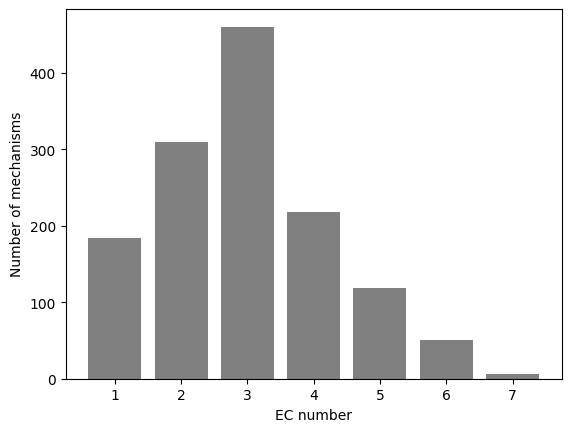

In [14]:
ecs = []
n_digits = 1
for eid in mech_df['entry_id']:
    ecs.append(entries[str(eid)]['reaction']['ec'])

ec_trunc = [elt[:n_digits] for elt in ecs]
ec_counts = Counter(ec_trunc)
ec_counts = sorted(ec_counts.items(), key=lambda x: x[0])

fig, ax = plt.subplots()
x = [i for i in range(len(ec_counts))]
ax.bar(x, [elt[1] for elt in ec_counts], color='gray')
ax.set_xticks(x)
ax.set_xticklabels([elt[0] for elt in ec_counts])
ax.set_xlabel('EC number')
ax.set_ylabel('Number of mechanisms')
plt.show()

In [15]:
def display_mech_labeled_rxn(entry_id: int, de_am: bool = False):
    these_mechs = mech_df.loc[mech_df['entry_id'] == entry_id]
    for _, row in these_mechs.iterrows():
        print(f"Mechanism: #{row['mechanism_id']}")
        smarts = row['am_smarts']
        lhs = [Chem.MolFromSmiles(elt) for elt in smarts.split('>>')[0].split('.')]
        rc_aidxs = row['reaction_center']
        mech_aidxs = row['mech_atoms']
        
        if de_am:
            for mol in lhs:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(0)

            smarts = '.'.join([Chem.MolToSmiles(mol) for mol in lhs]) + '>>' + smarts.split('>>')[1]
        
        # Display
        display(SVG(draw_reaction(smarts, sub_img_size=(150, 100))))
        for rct, rc, mech in zip(lhs, rc_aidxs[0], mech_aidxs[0]):
            involved_atoms = list(rc) + list(mech)
            display(SVG(draw_molecule(rct, size=(300, 200), highlight_atoms=involved_atoms, draw_options={"addAtomIndices": True})))

Mechanism: #1


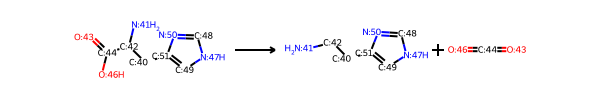

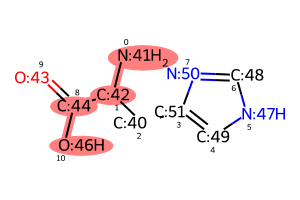

Mechanism: #1


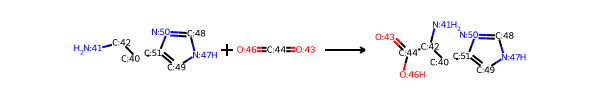

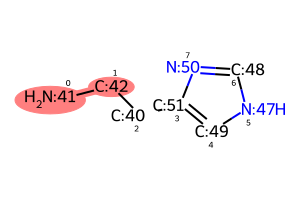

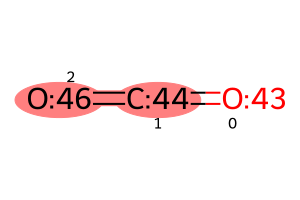

In [16]:
display_mech_labeled_rxn(49)

Mechanism: #1


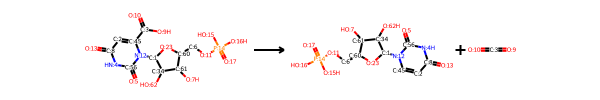

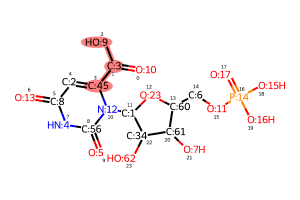

Mechanism: #1


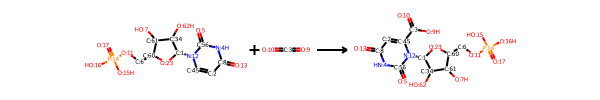

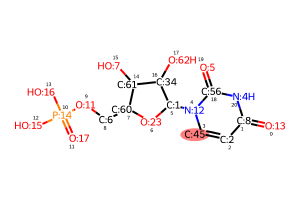

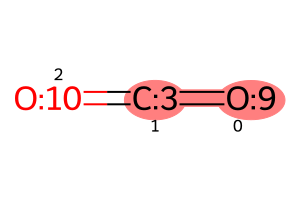

Mechanism: #3


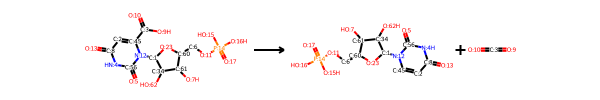

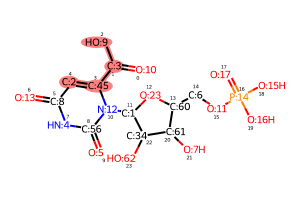

Mechanism: #3


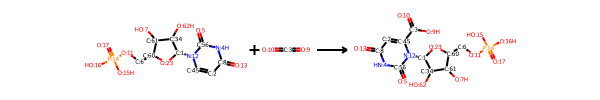

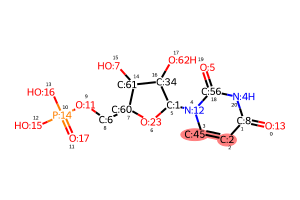

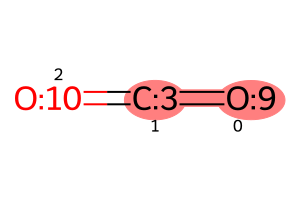

Mechanism: #2


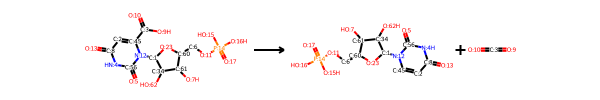

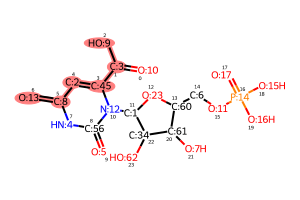

Mechanism: #2


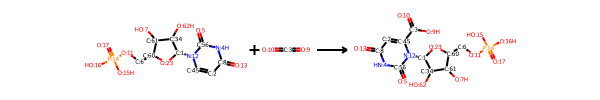

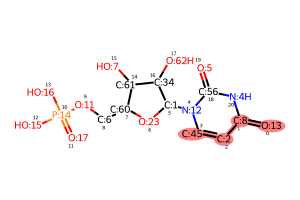

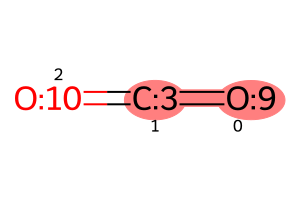

In [19]:
display_mech_labeled_rxn(50)

Mechanism: #1


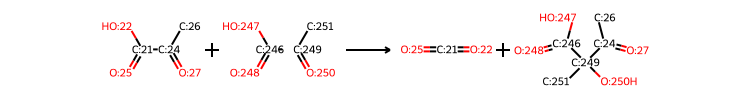

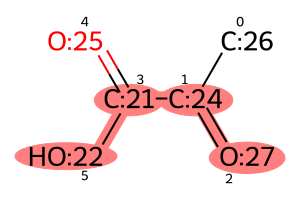

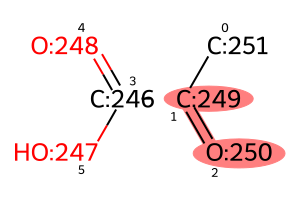

Mechanism: #1


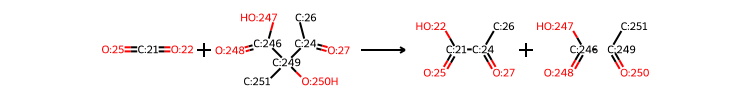

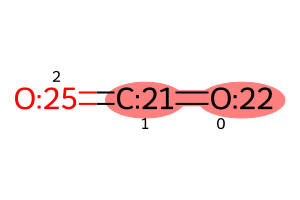

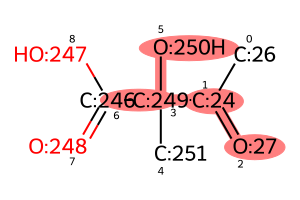

In [20]:
display_mech_labeled_rxn(722)

Mechanism: #1


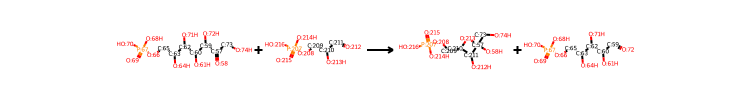

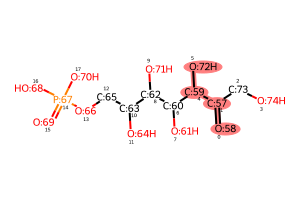

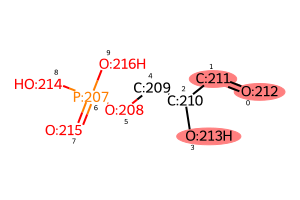

Mechanism: #1


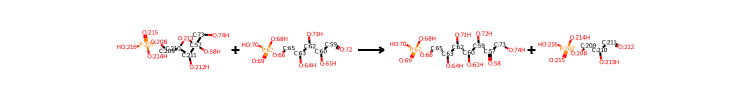

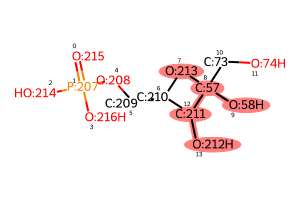

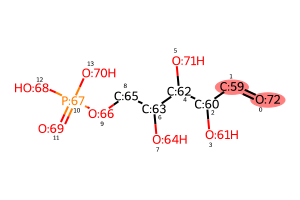

In [21]:
display_mech_labeled_rxn(219)

Mechanism: #2


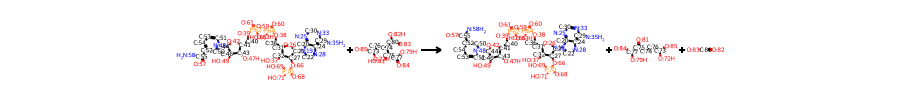

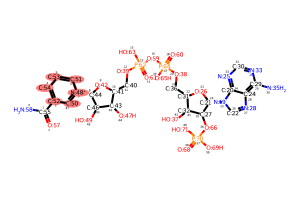

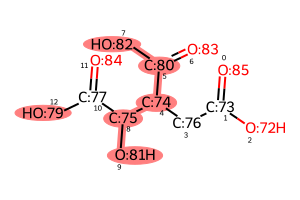

Mechanism: #2


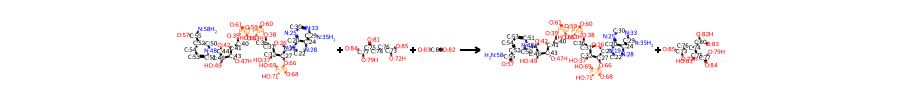

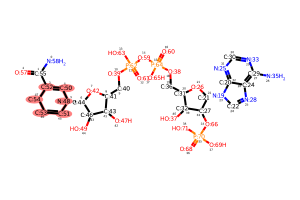

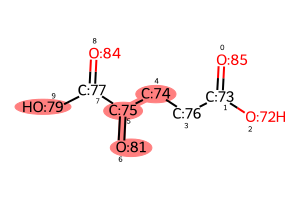

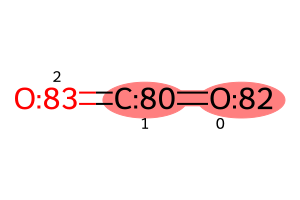

Mechanism: #1


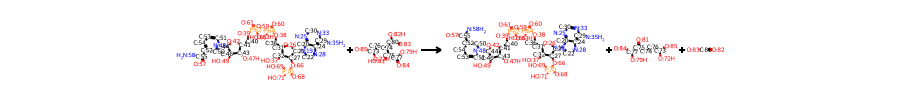

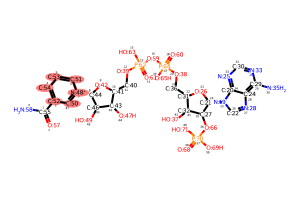

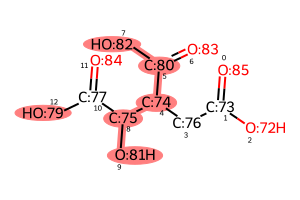

Mechanism: #1


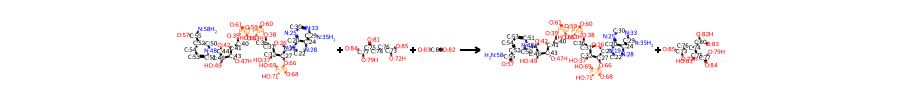

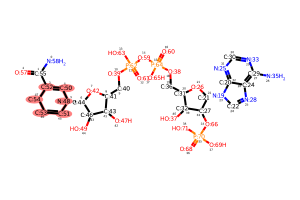

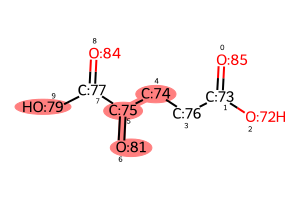

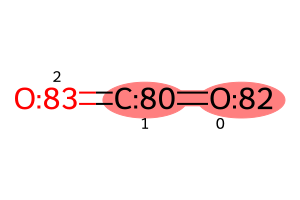

Mechanism: #3


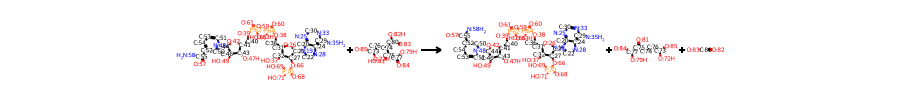

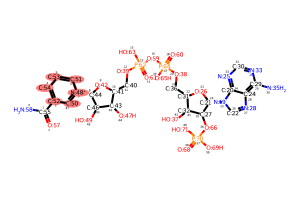

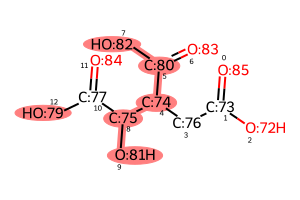

Mechanism: #3


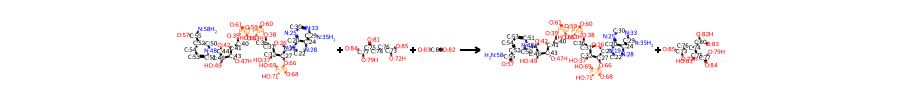

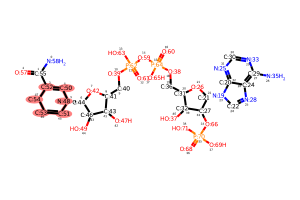

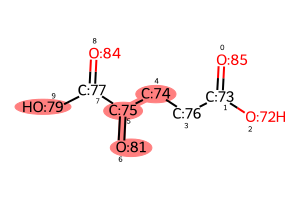

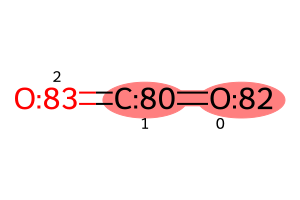

In [22]:
display_mech_labeled_rxn(7)

Mechanism: #2


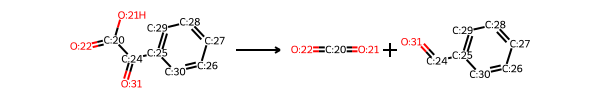

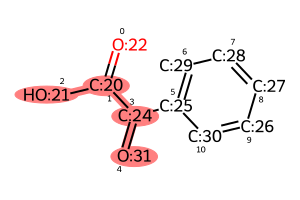

Mechanism: #2


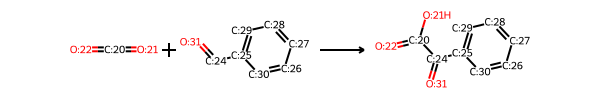

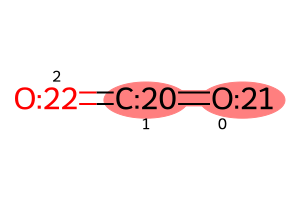

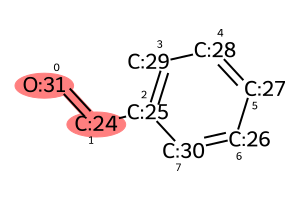

Mechanism: #3


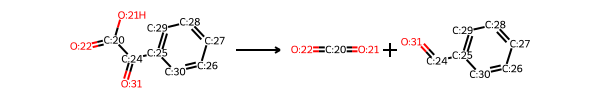

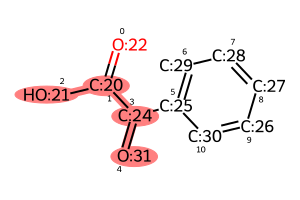

Mechanism: #3


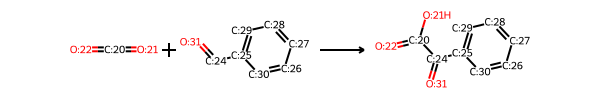

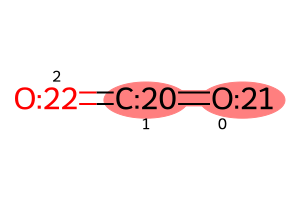

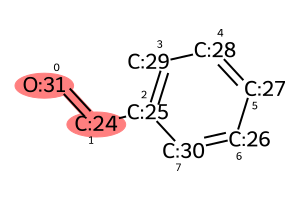

Mechanism: #1


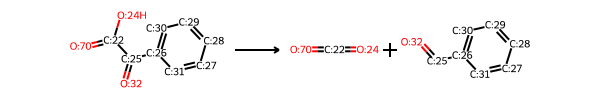

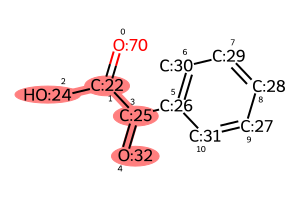

Mechanism: #1


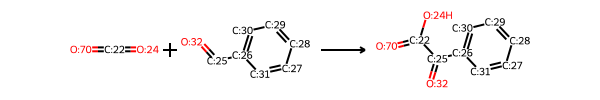

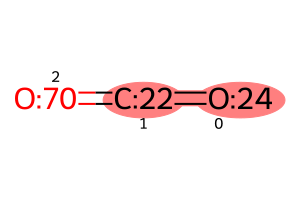

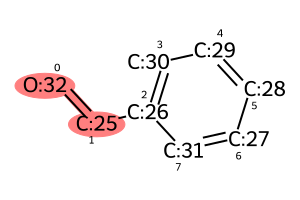

In [23]:
display_mech_labeled_rxn(220)

Mechanism: #1


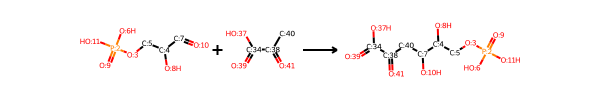

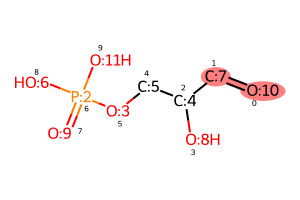

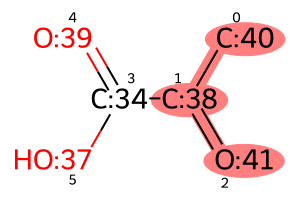

Mechanism: #1


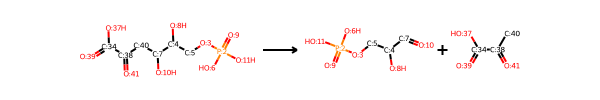

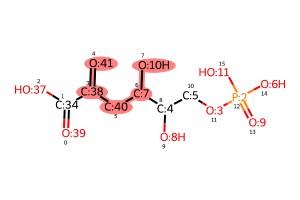

In [24]:
display_mech_labeled_rxn(550)

Mechanism: #1


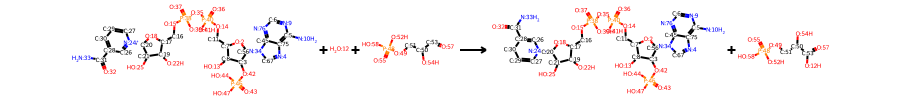

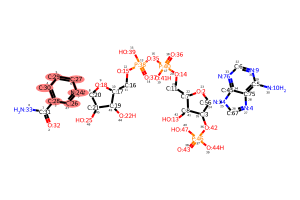

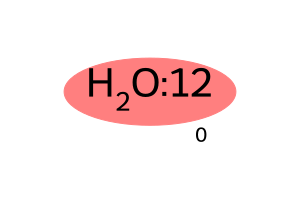

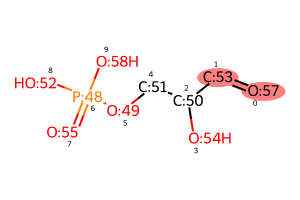

Mechanism: #1


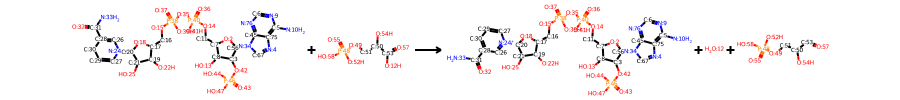

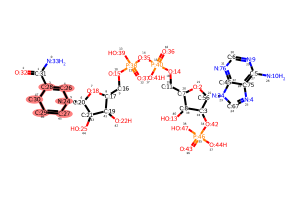

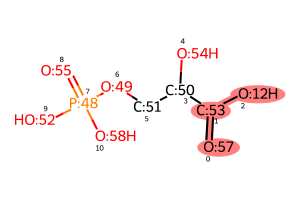

In [25]:
display_mech_labeled_rxn(711)

In [26]:
mm = pd.read_parquet(
    Path(filepaths.processed_data) / "mcsa" / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

entry_id  mechanism_id                                             smarts  \
0         2             2  *C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...   
1         2             1  *C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...   
2         3             1  *N1C=CCC(C(N)=O)=C1.O=C1C=CC(=O)C=C1>>*[n+]1cc...   
3         4             2                                        O=NO>>N=O.O   
4         4             1                                        O=NO>>N=O.O   

                                           am_smarts  \
0  [*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...   
1  [*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...   
2  [*:53][N:38]1[CH:37]=[CH:36][CH2:41][C:40]([C:...   
3    [O:52]=[N:53][O-:54]>>[NH2+:53]=[O:52].[OH2:54]   
4      [O:68]=[N:69][OH:70]>>[NH:69]=[O:68].[OH-:70]   

                                     reaction_center        mech_atoms  \
0                                       1,4;0>>1,4,7     5,6,7;>>5,6,9   
1                                    0,3,16;>>0,3,13  5,6,7;0>>5,6,7,9   
2  0,1,2,3,4,5;0,1,2,3,4,5,6,7>>0,1,2,3,4,5;0,1,2...              ;>>;   
3                                           1,2>>0;0             0>>1;   
4                                           1,2>>0;0             0>>1;   

                       enzyme_name uniprot_id       ec  
0         beta-lactamase (Class A)     P62593  3.5.2.6  
1         beta-lactamase (Class A)     P62593  3.5.2.6  
2  NAD(P)H dehydrogenase (quinone)     P15559  1.6.5.2  
3  nitrite reductase (copper type)     P25006  1.7.2.1  
4  nitrite reductase (copper type)     P25006  1.7.2.1

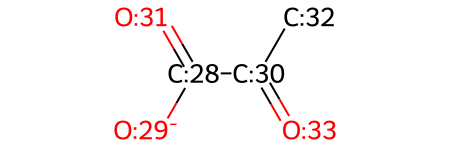

In [27]:
Chem.MolFromSmarts('[#6:28](-[#8-:29])(-[#6:30](-[#6H3:32])=[#8:33])=[#8:31]')